## Are pre-trained and custom LSTM models aware of island constraints?

Part of the code for tokenizing sentences and calculating token-by-token surprisal was adapted from https://github.com/kuribayashi4/surprisal_reading_time_en_ja, and edited in order to ensure that the code fits the purpose of this project and it runs without an issue in my environment.

### Load repository for calculating surprisals

In [ ]:
!git clone https://github.com/kuribayashi4/surprisal_reading_time_en_ja.git

Cloning into 'surprisal_reading_time_en_ja'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 41 (delta 10), reused 26 (delta 5), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [ ]:
%cd /content/surprisal_reading_time_en_ja

/content/surprisal_reading_time_en_ja


In [ ]:
#before executing this code, I changed the package name of "mecab" to "mecab-python3"
!pip install -r requirements.txt
!pip install unidic-lite

In [ ]:
#access files saved in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import necessary packages
import MeCab
import unidic
import unicodedata
import mojimoji
import torch
import sentencepiece as spm
import matplotlib.ticker as plticker
import pandas as pd
import japanize_matplotlib
import numpy as np

from torch.nn import CrossEntropyLoss
from fairseq.models.transformer_lm import TransformerLanguageModel
from fairseq.models.lstm_lm import LSTMLanguageModel
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

### LSTM pre-trained model

In [ ]:
#load the model
JA_MODEL_PATH = '/content/drive/MyDrive/Classes/LIGN 167 - FA22'

pretrained_lm = LSTMLanguageModel.from_pretrained(JA_MODEL_PATH,
                                                  'checkpoint_last_pretrained.pt',
                                                  data_name_or_path='japanese-dict',
                                                  bpe='sentencepiece',
                                                  sentencepiece_model='japanese-dict/spm/japanese_gpt2_unidic.model')

In [ ]:
#load word divider and SentencePiece tokenizer
wakati = MeCab.Tagger("-Owakati")
sp = spm.SentencePieceProcessor()
sp.Load("japanese-dict/spm/japanese_gpt2_unidic.model")

True

In [ ]:
def concat_bos(tensor, bos):
    return torch.cat([torch.tensor([bos]), tensor])

loss_fct = CrossEntropyLoss(ignore_index=-1, reduce=False)

def batch_surprisal(df, lm):
  dataset = pd.DataFrame(columns = ["island", "sent_number", "token", "surprisal"]) 
  sent_number = 0
  for i, row in df.iterrows():
    sent_number += 1
    tokens = []
    sent = unicodedata.normalize('NFKC', mojimoji.han_to_zen(row['sentence']))
    sent_wakati = wakati.parse(sent).strip()
    pieces = ' '.join(sp.EncodeAsPieces(sent_wakati))
    input_ids = lm.binarize(pieces)
    bos = lm.src_dict.bos()
    input_ids_with_special_token = concat_bos(input_ids, bos)

    results = lm.models[0](input_ids_with_special_token.view(1,-1))
    surprisals = loss_fct(results[0][0][:-1], input_ids)
    surprisals = surprisals.data.tolist()
    assert len(surprisals) == len(input_ids)
    
    for idx in input_ids:
      tokens.append(lm.src_dict[idx].strip('▁'))
    
    if row['island'] == 1:
      to_append = {'island': list(np.repeat(1, len(tokens), axis=0)),
                   'sent_number': list(np.repeat(sent_number, len(tokens), axis=0)),
                   'token': tokens,
                   'surprisal': surprisals}
      dataset = dataset.append(pd.DataFrame(to_append))
    elif row['island'] == 0:
      to_append = {'island': list(np.repeat(0, len(tokens), axis=0)),
                   'sent_number': list(np.repeat(sent_number, len(tokens), axis=0)),
                   'token': tokens,
                   'surprisal': surprisals}
      dataset = dataset.append(pd.DataFrame(to_append))

  return dataset

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Import test data, and compute token-by-token surprisal using the language model

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/test_stimuli_new.csv')

In [ ]:
#get and save the result
result = batch_surprisal(data, pretrained_lm)
result.to_csv('result_LSTM_pretrained.csv')

After exporting the result, I manually coded the region of interest (i.e., all the words following the noun that underwent long-distance relativization), and reimported the edited version.

Example: 

Because the book that __ wrote was featured in the news, <ins>the professor looks proud.</ins>

\[The book that __ wrote was featured in the news\] <ins>the professor looks proud.</ins>


In [ ]:
result_edited = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_LSTM_pretrained.csv')

In [ ]:
#get mean surprisal on the critical region by group (island=1/non-island=0)
critical = result_edited[result_edited['critical']==1]
critical.groupby('island')['surprisal'].mean()

island
0    4.817807
1    4.812105
Name: surprisal, dtype: float64

The results suggest that the pre-trained LSTM LM is no more surprised to see the sign of long-distance extraction with an island violation than the one without an island violation. In other words, the LM doesn't seem to be aware of the relative clause island constraint.

### LSTM model trained from scratch with additional data
As there is no straightfoward way to finetune this model (I need vocab data of the original training set, which is not available), I will merge finetuning data with the original training set, make a vocab file, and train a model from scratch.

#### Prepare finetuning data

In [ ]:
%cd '/content/drive/MyDrive/Classes/LIGN 167 - FA22/'

/content/drive/MyDrive/Classes/LIGN 167 - FA22


In [ ]:
ft_data = pd.read_csv('finetuning_stimuli.csv')

In [ ]:
#split between train and valid data
ft_data_val = ft_data.sample(n = 14)

ft_data_train = ft_data.drop(ft_data.index[ft_data_val.index.tolist()])

In [ ]:
#tokenize sentences and write to txt file
def tokenize_and_write(df, split):
  with open('finetuning_stimuli_{}.txt'.format(split), 'w') as f:
    for sent in df['sentence'].tolist():
      sent = unicodedata.normalize('NFKC', mojimoji.han_to_zen(sent))
      sent_wakati = wakati.parse(sent)
      f.write(' '.join(sp.EncodeAsPieces(sent_wakati)))
      f.write('\n')

tokenize_and_write(ft_data_train, 'train')
tokenize_and_write(ft_data_val, 'val')

Combine additional dataset with the original dataset used to train the pretrained LM tested above

In [ ]:
filenames = ['ja-lm-train-data/ja_train.txt', 'finetuning_stimuli_train.txt']
with open('combined_data/train.txt', 'w') as outfile:
  for fname in filenames:
    with open(fname) as infile:
      for line in infile:
        outfile.write(line)

In [ ]:
filenames = ['ja-lm-train-data/ja_dev.txt', 'finetuning_stimuli_val.txt']
with open('combined_data/val.txt', 'w') as outfile:
  for fname in filenames:
    with open(fname) as infile:
      for line in infile:
        outfile.write(line)

Binarize data via BPE (byte-pair encoding)

In [ ]:
!fairseq-preprocess --only-source \
--trainpref combined_data/train.txt \
--validpref combined_data/val.txt

2022-10-30 22:19:12 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang=None, srcdict=None, target_lang=None, task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, tpu=False, trainpref='combined_dat

#### Model training
All the parameters are the same as the ones used for the pretrained LM.

In [ ]:
!fairseq-train --task language_modeling \
  data-bin \
  --save-dir checkpoint \
  --save-interval-updates 10000 \
  --keep-interval-updates 10 \
  --keep-last-epochs 10 \
  --arch lstm_lm --share-decoder-input-output-embed \
  --dropout 0.1 \
  --decoder-layers 2 --decoder-hidden-size 1024 --decoder-embed-dim 400 --decoder-out-embed-dim 400 \
  --optimizer adam --adam-betas '(0.9, 0.98)' --weight-decay 0.0000012 --clip-norm 0.0  \
  --lr  0.001 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
  --tokens-per-sample 512 --sample-break-mode none \
  --max-tokens 512 --update-freq 10 \
  --log-format json --log-interval 10 --max-update 1000 | tee -a checkpoint/100000_updates/train.log

tee: checkpoint/100000_updates/train.log: No such file or directory
2022-11-01 00:05:37 | INFO | fairseq_cli.train | Namespace(adam_betas='(0.9, 0.98)', adam_eps=1e-08, adaptive_softmax_cutoff='10000,50000,200000', add_bos_token=False, all_gather_list_size=16384, arch='lstm_lm', batch_size=None, batch_size_valid=None, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_shard_count=1, checkpoint_suffix='', clip_norm=0.0, cpu=False, criterion='cross_entropy', curriculum=0, data='data-bin', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', decoder_attention='0', decoder_dropout_in=0.1, decoder_dropout_out=0.1, decoder_embed_dim=400, decoder_embed_path=None, decoder_hidden_size=1024, decoder_layers=2, decoder_out_embed_dim=400, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_num_procs=1, distributed_port=-1, distributed_rank=0, distribute

In [ ]:
%cd '/content/drive/MyDrive/Classes/LIGN 167 - FA22/'

/content/drive/MyDrive/Classes/LIGN 167 - FA22


In [ ]:
#load the custom model
JA_MODEL_PATH = 'checkpoint/'

custom_lm = LSTMLanguageModel.from_pretrained(JA_MODEL_PATH,
                                              'checkpoint_last_custom.pt',
                                              data_name_or_path='data-bin',
                                              bpe='sentencepiece',
                                              sentencepiece_model='/content/surprisal_reading_time_en_ja/japanese-dict/spm/japanese_gpt2_unidic.model')

In [ ]:
#get and save the result
result = batch_surprisal(data, custom_lm)
result.to_csv('result_LSTM_custom.csv')

In [ ]:
result_edited = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_LSTM_custom.csv')

In [ ]:
#get mean surprisal on the critical region by group (island=1/non-island=0)
critical = result_edited[result_edited['critical']==1]
critical.groupby('island')['surprisal'].mean()

island
0    5.013356
1    5.045783
Name: surprisal, dtype: float64

Despite finetuning, surprisals associated with words that have undergone long-distance extraction are comparable between the two conditions. The results suggest either that LSTM LMs need more data in order to learn the island constraint, or LSTM is not capable of learning the constraint. 

### Visualize results
Code below visualizes the surprisals associated with words that have undergone long-distance extraction (across island and non-island) and all subsequent words.

In [ ]:
pretrained = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_LSTM_pretrained.csv')
custom = pd.read_csv('/content/drive/MyDrive/Classes/LIGN 167 - FA22/result_LSTM_custom.csv')

In [ ]:
def add_token_num(df):
  token_number = []
  for i in df['sent_number'].unique():
    token_number.extend(range(1,len(df[df['sent_number'] == i])+1))
  df['token_number'] = token_number
  return df

In [ ]:
pretrained = add_token_num(pretrained)
custom = add_token_num(custom)

In [ ]:
figure(figsize = (10, 6))

for i in range(1,5):
  subset = pretrained[(pretrained['sent_number']==i)&(pretrained['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='blue')

for i in range(9,13):
  subset = pretrained[(pretrained['sent_number']==i)&(pretrained['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='red')

plt.show()

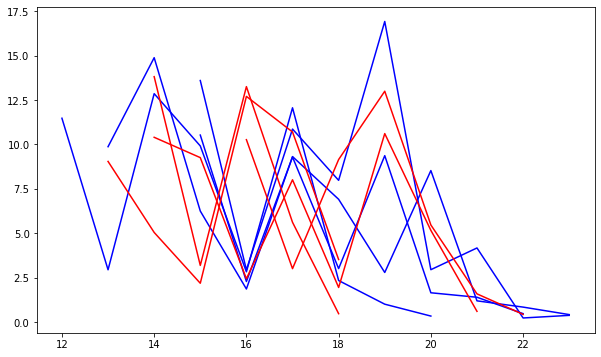

In [ ]:
figure(figsize = (10, 6))

for i in range(1,5):
  subset = custom[(custom['sent_number']==i)&(custom['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='blue')

for i in range(9,13):
  subset = custom[(custom['sent_number']==i)&(custom['critical']==1)]
  plt.plot(subset['token_number'], subset['surprisal'], color='red')

plt.show()